# Import Tensflow Library

In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Load The Data

In [2]:
(train_data,test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True, #(image, label)
                                            with_info=True, #dataset metadata
                                            )

In [3]:
class_names = ds_info.features['label'].names

In [4]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
for image, label in train_one_sample:
  print(f"Image shape: {image.shape}")
  print(f"Image data type: {image.dtype}")
  print(f"Image Label: {label}")
  print(f"Image ClassName: {class_names[label]}")

Image shape: (512, 512, 3)
Image data type: <dtype: 'uint8'>
Image Label: 49
Image ClassName: grilled_cheese_sandwich


In [6]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'grilled_cheese_sandwich')

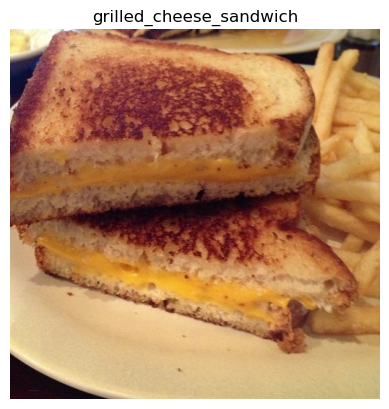

In [7]:
#Plot the image
plt.imshow(image/255)
plt.axis(False)
plt.title(class_names[label])

# 2. Data Preprocessing

In [8]:
# function for preprocessing images ( resize and type casting)
def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [9]:
# Resize and type cast
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [70]:
# Turn on mixed precision training b4 building the model
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16")

# 3. Building CNN Model

## 3.1 Feature Extraction  Model

In [11]:
from tensorflow.keras import layers

# create model
def create_model():
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  input = layers.Input(shape=(224,224,3), name="Input_layer")

  x = base_model(input, training=False)
  x = layers.GlobalAveragePooling2D(name="Pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)

  output = layers.Activation("softmax", dtype=tf.float32, name="Softmax_float32")(x)

  model = tf.keras.Model(input, output)

  return model


In [31]:
#check model summary
model_1 = create_model()
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 Softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [32]:
#Creates a TensorBoard callback
# tensorboard_callback_path =  "m2/tensorboard_callback/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#   log_dir=tensorboard_callback_path
#   )

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "m3/model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [33]:
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [17]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch = len(train_data),
                        validation_data= test_data,
                        validation_steps= int(0.15 * len(test_data)),
                        callbacks=[model_checkpoint])


Epoch 1/5
2368/2368 [==============================] - 203s 81ms/step - loss: 1.7147 - accuracy: 0.5845 - val_loss: 1.1398 - val_accuracy: 0.6933
Epoch 2/5
2368/2368 [==============================] - 187s 78ms/step - loss: 1.1988 - accuracy: 0.6903 - val_loss: 1.0367 - val_accuracy: 0.7137
Epoch 3/5
2368/2368 [==============================] - 189s 79ms/step - loss: 1.0540 - accuracy: 0.7247 - val_loss: 0.9949 - val_accuracy: 0.7246
Epoch 4/5
2368/2368 [==============================] - 185s 77ms/step - loss: 0.9591 - accuracy: 0.7466 - val_loss: 0.9721 - val_accuracy: 0.7378
Epoch 5/5
2368/2368 [==============================] - 182s 76ms/step - loss: 0.8891 - accuracy: 0.7664 - val_loss: 0.9766 - val_accuracy: 0.7320


In [18]:
result1 = model_1.evaluate(test_data)
result1

790/790 [==============================] - 62s 78ms/step - loss: 0.9790 - accuracy: 0.7324


[0.9789710640907288, 0.7323564291000366]

In [19]:
#save model
save_dir = "drive/MyDrive/m3/Feature_extraction_model_1"
model_1.save(save_dir)

In [34]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_1)

NameError: name 'history_1' is not defined

# 3.2 Fine Tuning The Model

In [35]:
# More model check points

early_stoping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=3)

model_checkpoint_fine_tuning = tf.keras.callbacks.ModelCheckpoint(filepath="fine_tune_checkpoint/",
                                                                  save_best_only=True,
                                                                  monitor="val_loss")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1,
                                                  min_lr=1e-7)

In [36]:
# Making the effecientnet layers trainable for fine tuning
for layer in model_1.layers:
  layer.trainable = True
  print(layer.name, layer.trainable)

Input_layer True
efficientnetb0 True
Pooling_layer True
dense_1 True
Softmax_float32 True


In [38]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 Softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [39]:
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"]
                )

In [25]:
history_3 = model_1.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps= int(0.15 * len(test_data)),
                        callbacks = [early_stoping, model_checkpoint_fine_tuning, lr_callback])

Epoch 1/100
2368/2368 [==============================] - 681s 267ms/step - loss: 0.7933 - accuracy: 0.7825 - val_loss: 0.8273 - val_accuracy: 0.7717 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 636s 267ms/step - loss: 0.4744 - accuracy: 0.8667 - val_loss: 0.8196 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 604s 254ms/step - loss: 0.2627 - accuracy: 0.9237 - val_loss: 0.9035 - val_accuracy: 0.7744 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9569
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 601s 253ms/step - loss: 0.1431 - accuracy: 0.9569 - val_loss: 0.9978 - val_accuracy: 0.7810 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 613s 258ms/step - loss: 0.0292 - accuracy: 0.9932 - val_loss: 1.0264 - val_accuracy: 0.8043 - lr: 2.0000e-05


In [26]:
#save model
save_dir = "drive/MyDrive/m3/Fine_Tune_model_1"
model_1.save(save_dir)

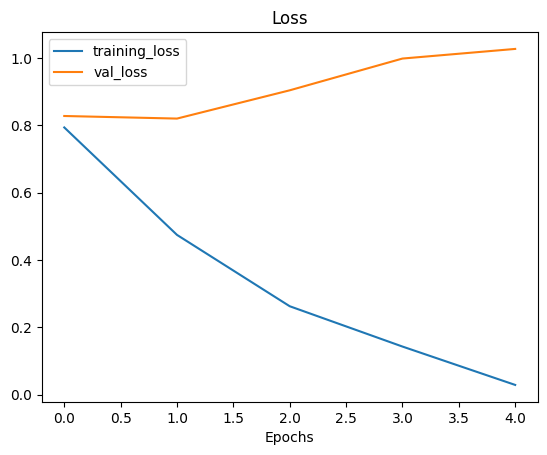

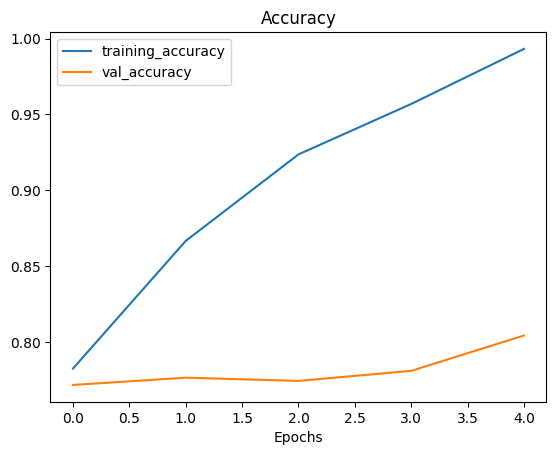

In [27]:
plot_loss_curves(history_3)

In [28]:
model_1.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.0501 - accuracy: 0.7991


[1.0501106977462769, 0.7990891337394714]

# 4. Make Prediction

In [15]:
img = tf.io.read_file("C:/Users/Abdiladif Hassan/DEV/Ai/test2.jpg")
img = tf.image.decode_image(img, channels=3)
img = tf.image.resize(img, (224, 224))  # Resize the image to match the input size of your model
img_array = tf.expand_dims(img, axis=0)

In [16]:
m1_prediction = model_1.predict(img_array)
label = m1_prediction.argmax()
class_names[label]

1/1 [==============================] - 4s 4s/step


'baby_back_ribs'

# 5. Load the Samed model and Make Prediction

In [40]:
loaded_model = tf.keras.models.load_model("C:/Users/Abdiladif Hassan/DEV/Ai/M3 Fine Tune")

In [41]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 Softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [44]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 542s 685ms/step - loss: 1.0501 - accuracy: 0.7991


[1.0501099824905396, 0.7990891337394714]

In [28]:
# Prepare the image for prediction
img = tf.io.read_file("C:/Users/Abdiladif Hassan/DEV/Ai/Test Images/grilled_salmon.jpeg")
img = tf.image.decode_image(img, channels=3)
img = tf.image.resize(img, (224, 224))  # Resize the image to match the input size of your model
img_array = tf.expand_dims(img, axis=0)

In [29]:
predictions = loaded_model.predict(img_array)
label_2 = predictions.argmax()
class_names[label_2]

1/1 [==============================] - 0s 77ms/step


'grilled_salmon'